# Simple regression

In [1]:
import jax
import jax.numpy as jnp
from pcv.inference import run_cv_sel, cv_adaptation, one_model_inference, simple_cv_adaptation
from pcv.plots import plot_model_results, plot_fold_results
from pcv.models import reg
from pcv.rules import make_positive_rule, make_positive_negative_rule
import matplotlib.pyplot as plt
import arviz as az

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Model definition

Gaussian linear regression, with an outlier injected into the data

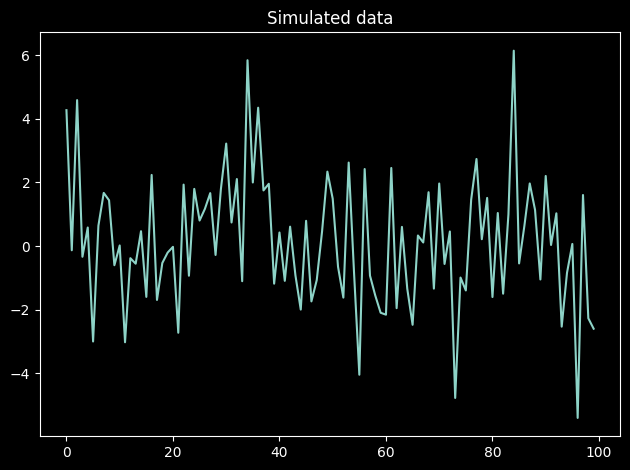

In [2]:
y, X = reg.generate(
    key=jax.random.PRNGKey(0),
    N = 100,
    beta0 = jnp.array([1.0, 1.0, 1.0, 0.5]),
    sigsq0 = jnp.array(2.0))

plt.plot(y)
plt.title('Simulated data')
plt.tight_layout()

In [3]:
K = 10
model = reg.get_model(y, X, K=K)

First, run model diagnostics.

In [4]:
idata, state = one_model_inference(
    prng_key=jax.random.PRNGKey(0),
    model=model,
    model_id=0,
    num_chains=32,
    num_samples=10_000,
    warmup_iter=10_000,
    prior_only=False
)

In [5]:
az.summary(idata, var_names=['beta', 'sigsq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[0],0.774,0.146,0.502,1.054,0.001,0.000,64233.0,101497.0,1.0
beta[1],0.813,0.140,0.548,1.074,0.001,0.000,74661.0,116271.0,1.0
beta[2],0.831,0.124,0.596,1.063,0.000,0.000,77542.0,120854.0,1.0
beta[3],0.371,0.138,0.110,0.630,0.001,0.000,70369.0,109810.0,1.0
sigsq,1.910,0.271,1.424,2.425,0.001,0.001,59311.0,92857.0,1.0


In [6]:
print(state.divergences)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


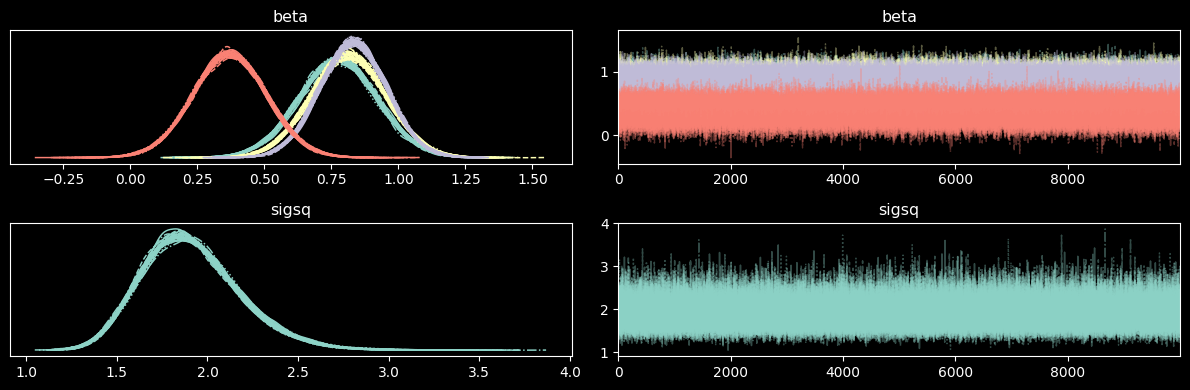

In [7]:
axes = az.plot_trace(idata)
plt.tight_layout()

## Cross-Validation


In [8]:
warmup_results = simple_cv_adaptation(
    prng_key=jax.random.PRNGKey(42),
    model=model,
    warmup_model_id=0,
    num_chains=4,
    adaptation_iter=1_000,
    burnin_iter=500,
    batch_size=100,
)

MEADS warmup for 2 model(s) (8 chains)...
Meads warmup done in 3.60 seconds. 
Step size: 0.5357 Alpha: 0.5644 Delta: 0.2822
Approximated 20 modes in 0 min 0.7 sec
Burn-in for 80 chains run took 0 min 4.5 sec


In [9]:
results = run_cv_sel(
       prng_key=jax.random.PRNGKey(0),
       model=model,
       stoprule=make_positive_negative_rule(num_folds=model.num_folds, level=0.95),
       warmup_results=warmup_results,
       batch_size=100,
       max_batches=50,
       ignore_stoprule=True,
       prior_only=False
)

Starting cross-validation with 80 parallel GHMC chains...
   0.  Model A: -194.65 ±1.60 ess 18244, Model B: -196.85 ±1.72 ess 18418
       Diff: 2.20 ±2.45, Rhat < 1.0300  stop
       Triggered stoprule after 1 batches in 3 seconds
  10.  Model A: -180.65 ±1.57 ess 46619, Model B: -183.46 ±1.74 ess 48414
       Diff: 2.81 ±2.21, Rhat < 1.0101  stop
  20.  Model A: -179.17 ±1.58 ess 70204, Model B: -181.79 ±1.74 ess 74023
       Diff: 2.62 ±2.18, Rhat < 1.0094  stop
  30.  Model A: -178.46 ±1.58 ess 93422, Model B: -181.28 ±1.74 ess 97979
       Diff: 2.82 ±2.17, Rhat < 1.0076  stop
  40.  Model A: -178.10 ±1.58 ess 115897, Model B: -181.03 ±1.75 ess 122130
       Diff: 2.93 ±2.19, Rhat < 1.0077  stop
  49.  Model A: -177.95 ±1.58 ess 135419, Model B: -180.77 ±1.75 ess 143310
       Diff: 2.83 ±2.21, Rhat < 1.0060  stop
Drew 400000 samples in 1 min 36 sec (4153 per sec)


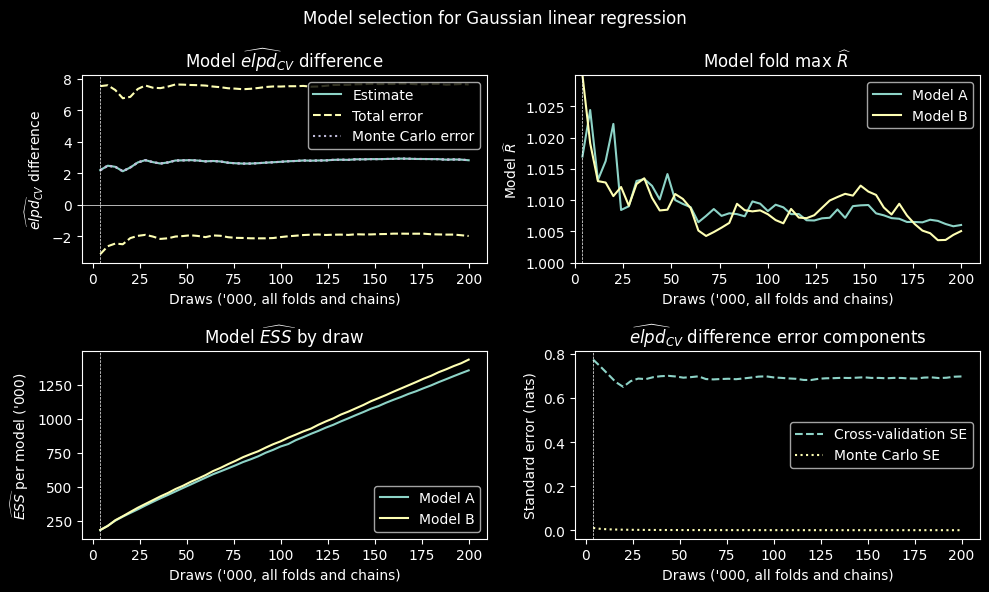

In [10]:
plot_model_results(results, title="Model selection for Gaussian linear regression")

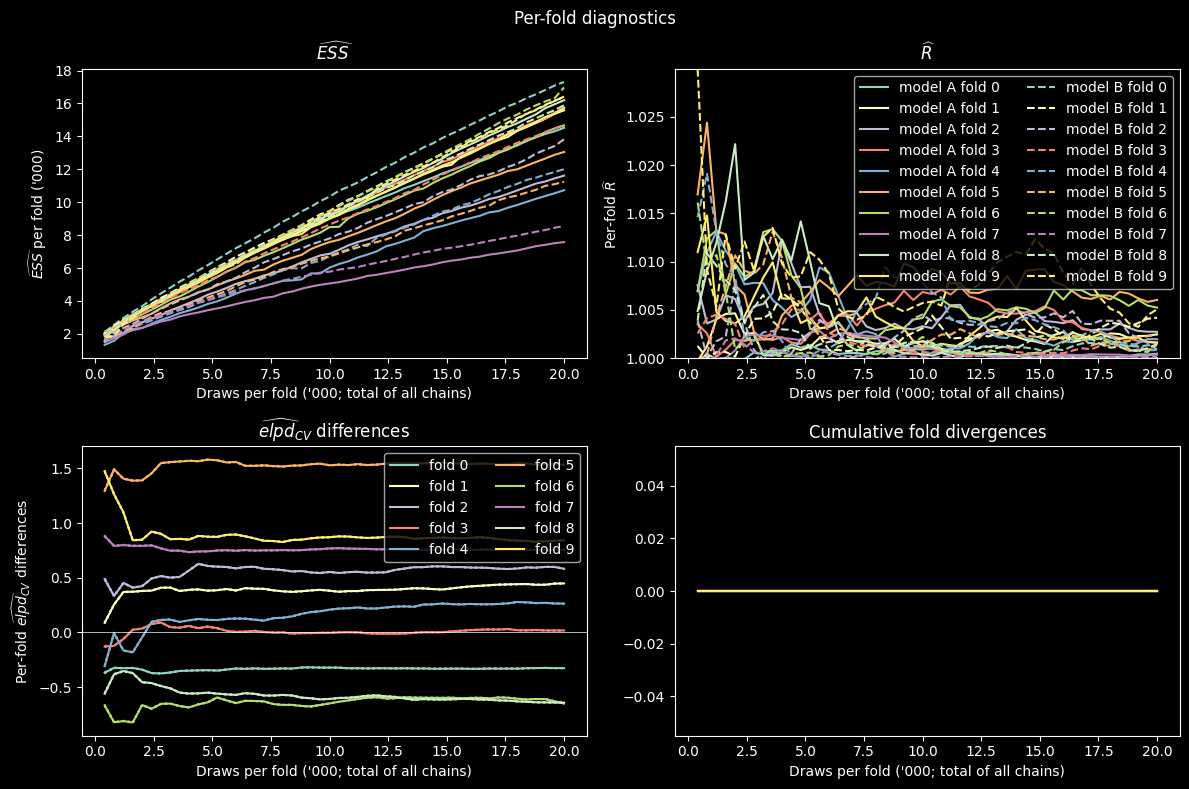

In [11]:
plot_fold_results(results, title='Per-fold diagnostics')